In [1]:
import torch as t
from torch.autograd import Variable


In [2]:
x = Variable(t.ones(2,2), requires_grad=True) ; x

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

In [3]:
y = t.sum(x) ;y


Variable containing:
 4
[torch.FloatTensor of size 1]

In [11]:
y.grad_fn

In [12]:
y.backward()

In [13]:
x.grad

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

In [14]:
y.backward()

In [15]:
x.grad

Variable containing:
 2  2
 2  2
[torch.FloatTensor of size 2x2]

In [20]:
x.grad.data.zero_()


 0  0
 0  0
[torch.FloatTensor of size 2x2]

In [21]:
y.backward()

In [22]:
x.grad

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

 implement LeNet
 定义网络时，需要继承nn.Module，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数__init__中。如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用nn.functional代替。
 

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:


class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net,self).__init__()
        
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(1,6,5)
        # 卷积层
        self.conv2 = nn.Conv2d(6,16,5)
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2)) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x) )
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
for name , parameter in net.named_parameters():
    print(name ,':' ,parameter.size())
    

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


CIFAR-10分类
下面我们来尝试实现对CIFAR-10数据集的分类，步骤如下:
使用torchvision加载并预处理CIFAR-10数据集


定义损失函数和优化器
训练网络并更新网络参数
测试网络

CIFAR-10数据加载及预处理

CIFAR-10^3是一个常用的彩色图片数据集，它有10个类别: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。每张图片都是 3×32×32
 ，也即3-通道彩色图片，分辨率为 32×32
 。

In [8]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

In [10]:
trainset = tv.datasets.CIFAR10(root='/home/paperspace/data/pythorch_book/ch02', 
                               train=True, 
                               transform=transform, 
                               download=True)

In [11]:
trainloader = t.utils.data.DataLoader(trainset, batch_size=4, shuffle=True ,num_workers=2)

In [12]:
testset = tv.datasets.CIFAR10(root='/home/paperspace/data/pythorch_book/ch02', 
                               train=False, 
                               transform=transform, 
                               download=True)

Files already downloaded and verified


In [13]:
testloader = t.utils.data.DataLoader(testset, batch_size=4 , shuffle=False, num_workers=2)

In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ship


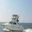

In [15]:
(data, label)=trainset[100]
print(classes[label])
show((data+1)/2)

In [16]:
class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net,self).__init__()
        
        # 卷积层 '3'表示输入图片为3通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(3,6,5)
        # 卷积层
        self.conv2 = nn.Conv2d(6,16,5)
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2)) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x) )
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


定义损失函数和优化器


In [17]:
from torch import optim
optimizer = optim.SGD(net.parameters(),lr=0.001 , momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [23]:
t.set_num_threads(8)

for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
       
            
        # 输入数据
        inputs , labels = data
        inputs , labels = Variable(inputs) , Variable(labels)
        
        if t.cuda.is_available():
            net.cuda()
            inputs = inputs.cuda()
            labels = labels.cuda()
            #output = net(inputs)
            #loss= criterion(output,labels)
            
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        running_loss += loss.data[0]
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 0.778
[1,  4000] loss: 0.810
[1,  6000] loss: 0.827
[1,  8000] loss: 0.847
[1, 10000] loss: 0.877
[1, 12000] loss: 0.859
[2,  2000] loss: 0.756
[2,  4000] loss: 0.762
[2,  6000] loss: 0.822
[2,  8000] loss: 0.817
[2, 10000] loss: 0.829
[2, 12000] loss: 0.855
Finished Training


实际的label:       cat     ship     ship    plane


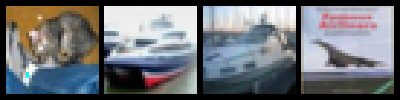

In [31]:
dataiter = iter(testloader)
images,labels =dataiter.next()
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [32]:
outputs = net(Variable(images.cuda()))
probs , predicts = t.max(outputs.data,1)

In [33]:
print('預測的label: ', ' '.join(\
            '%08s'%classes[predicts[j]] for j in range(4)))

預測的label:       cat      car      car    plane


In [50]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


for data in testloader:
    images, labels = data
    
    if t.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        net.cuda()
            
    outputs = net(Variable(images))
    _, predicted = t.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum()


print(correct,total)
print("10000張預測準確率：", correct/total )
    
    

6306 10000
10000張預測準確率： 0.6306


Cuda version
